## MRI Preprocessing

### Preprocessing Considerations for DCE-MRI
In DCE-MRI, the dynamic nature of contrast agent distribution makes traditional normalization methods less suitable. Focus on maintaining the integrity of the time-resolved data and consider methods that preserve the clinical relevance of intensity variations related to contrast enhancement. Whenever possible, evaluate the impact of any preprocessing step on your specific analysis goals and ensure that the normalization techniques align with the objectives of your study.

### MRI Preprocessing Steps

1. **N4 Bias Correction** (Optional)  
   Corrects for intensity inhomogeneities and biases, which can enhance the accuracy of subsequent analyses.
   > **Important Note**: In DCE-MRI, bias correction can inadvertently alter the appearance of contrast-enhanced regions. To mitigate this, many DCE-MRI protocols use N4 Bias Correction cautiously, applying it to baseline images before the contrast agent is introduced or using region-specific adjustments that preserve contrast dynamics where needed.

2. **Denoising** (Optional)  
   NLMeans is a non-linear filter that averages similar patches throughout the image, allowing it to selectively reduce noise without sacrificing edges and subtle intensity variations. Applying denoising can improve image quality but should be done carefully, especially if it follows normalization or histogram equalization. In such cases, it may inadvertently amplify noise or artifacts introduced in previous steps.

   > **Note**: If applied after normalization or histogram equalization, denoising can sometimes amplify noise, especially if these steps have introduced artifacts.

3. **Intensity Clipping** to Percentile Range (Optional, use with caution)  
   Clipping intensity values to a defined percentile range can help reduce outliers, though it may not always be necessary.

4. **Normalization (Z-score)** (Optional; **Not recommended for DCE-MRI**)  
   Z-score normalization is typically discouraged for DCE-MRI data due to its potential to obscure dynamic intensity changes that are clinically relevant.

5. **Histogram Equalization** (Optional; **Not recommended for DCE-MRI**)  
   Histogram equalization may distort the intensity distribution and is generally avoided in DCE-MRI studies. If necessary, consider region-specific techniques.

   > **Note**: Performing histogram equalization before normalization may lead to data distortions, potentially impacting statistical analyses.

6. **Resampling** (Recommended)  
   Resampling to a consistent voxel size can help standardize the data, making comparisons more reliable across images.

In [1]:
# Load preprocessing and visualization methods
import sys
sys.path.append('..')  # Add the parent directory to the path
from src.visualization import *
from src.preprocessing import *

In [2]:
# Define the dataset paths and folders (adjust path if necessary)
dataset_path = '/datasets/mama_mia_dataset'
images_folder = dataset_path + '/images'
expert_segmentations = dataset_path + '/segmentations/expert'

# Select a random patient to visualize the segmentation
patient_id = 'DUKE_001' #'ISPY1_1001' # 'DUKE_001'
# Load the first post-contrast MRI image (phase=1) for demo purposes
phase_1_sitk = read_mri_phase_from_patient_id(images_folder, patient_id, phase=1)

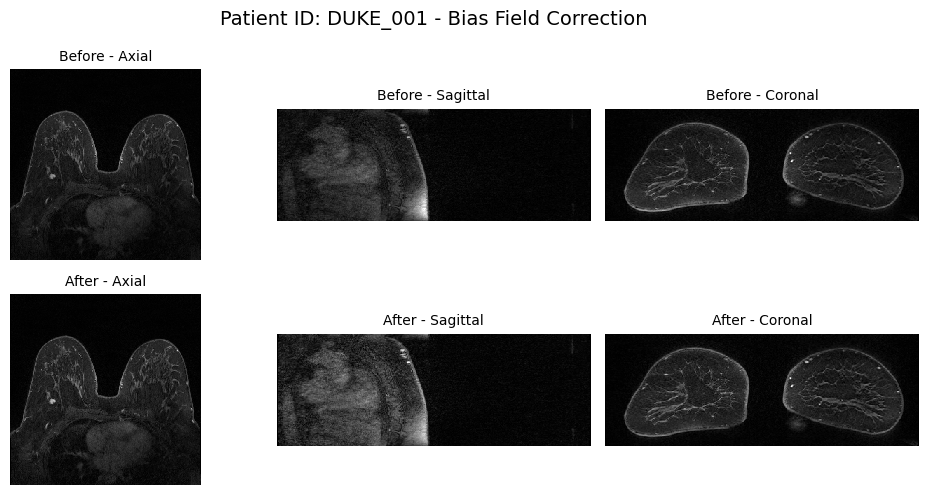

In [3]:
# 1. Bias field correction
# Bias field correction is a slow process, the process can be accelerated by setting the shrink_factor to a higher value (e.g. 2)
bias_corrected_sitk = bias_correction_sitk(phase_1_sitk, otsu_threshold=True, shrink_factor=4)

# Visualize the bias corrected image
plot_mri_preprocessing(phase_1_sitk, bias_corrected_sitk, patient_id, preprocessing_method='Bias Field Correction', figsize=(10, 5))
# Run to play with an interactive plot
# interactive_plot_mri_preprocessing(phase_1_sitk, bias_corrected_sitk, patient_id, preprocessing_method='Bias Field Correction', figsize=(10, 5))

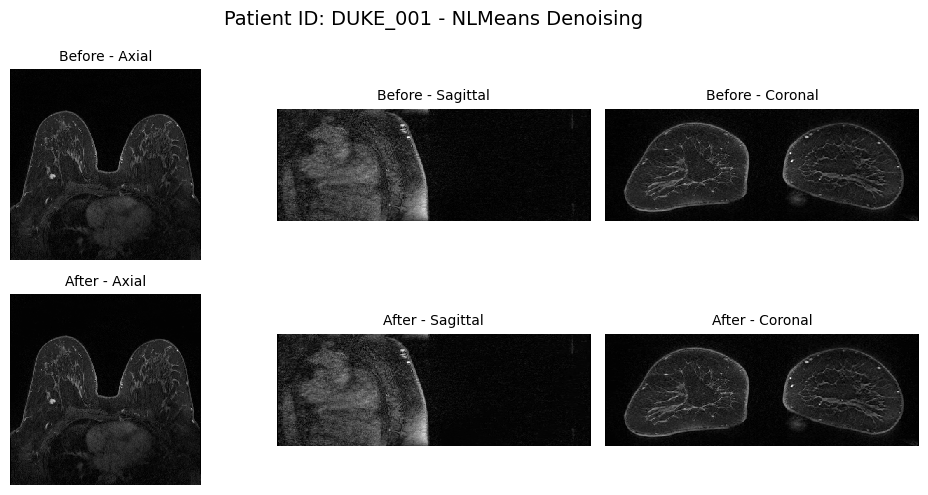

In [4]:
# 2. NLMeans Denoising
denoised_sitk = nlmeans_denoise_sitk(bias_corrected_sitk, patch_size=5, patch_distance=6, h=0.8)

plot_mri_preprocessing(bias_corrected_sitk, denoised_sitk, patient_id, preprocessing_method='NLMeans Denoising', figsize=(10, 5))
# Run to play with an interactive plot
# interactive_plot_mri_preprocessing(bias_corrected_sitk, denoised_sitk, patient_id, preprocessing_method='NLMeans Denoising', figsize=(10, 5))

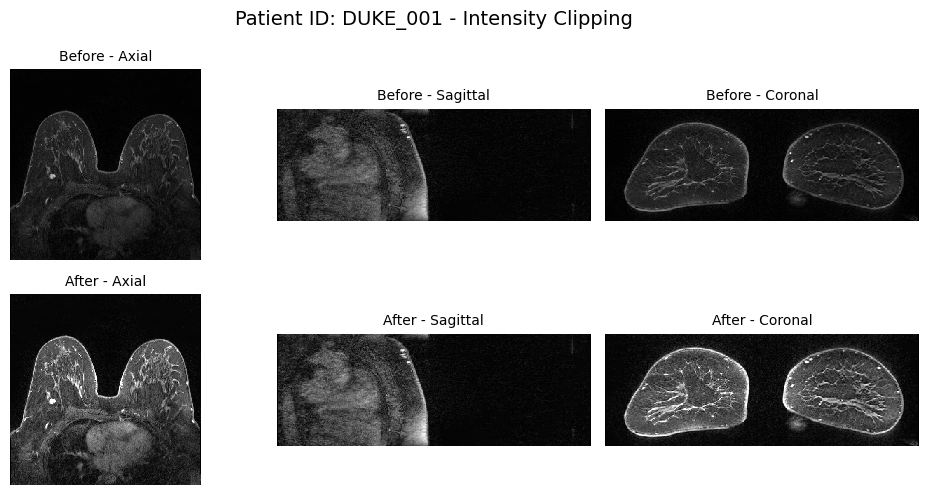

In [5]:
# 3. Intensity Clipping to Percentile Range (Note: This step is optional and can be skipped)
clipped_sitk = clip_image_sitk(denoised_sitk, percentiles=[0.1, 99.9])

plot_mri_preprocessing(denoised_sitk, clipped_sitk, patient_id, preprocessing_method='Intensity Clipping', figsize=(10, 5))
# Run to play with an interactive plot
# interactive_plot_mri_preprocessing(denoised_sitk, clipped_sitk, patient_id, preprocessing_method='Intensity Clipping', figsize=(10, 5))

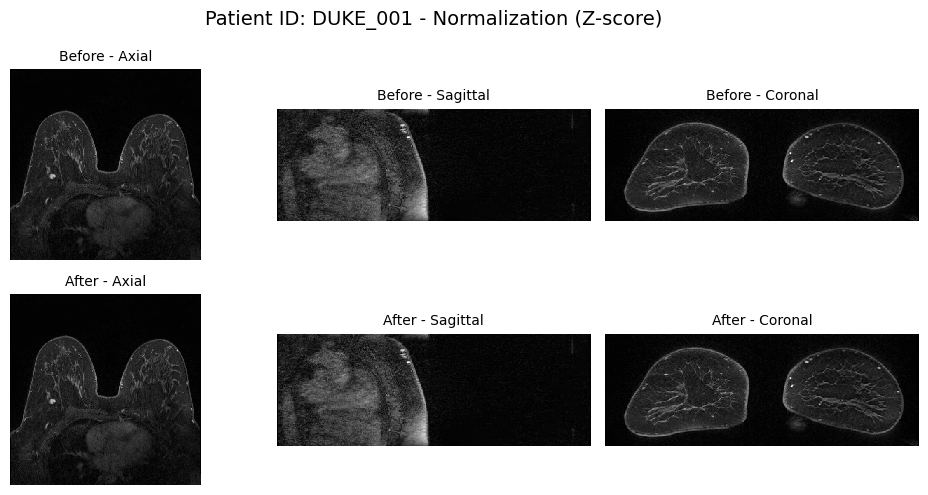

In [6]:
# 4. Normalization (Z-score)
# In DCE-MRI it is recommended to normalize each phase taking into account the mean and standard deviation of all the phases in the DCE-MRI sequence

# For demo purposes, we will use the mean and standard deviation of the current phase
LabelFilter = sitk.StatisticsImageFilter()
LabelFilter.Execute(clipped_sitk)
mean = LabelFilter.GetMean()
std = LabelFilter.GetSigma()
normalized_stik = zscore_normalization_sitk(denoised_sitk, mean, std)

plot_mri_preprocessing(denoised_sitk, normalized_stik, patient_id, preprocessing_method='Normalization (Z-score)', figsize=(10, 5))
# Run to play with an interactive plot
# interactive_plot_mri_preprocessing(denoised_sitk, normalized_stik, patient_id, preprocessing_method='Normalization (Z-score)', figsize=(10, 5))

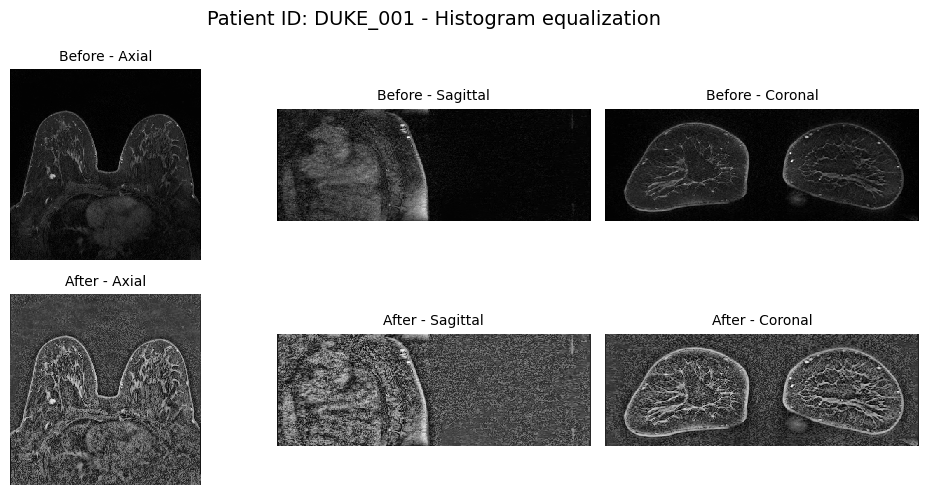

In [7]:
# 5. Histogram Equalization (Not recommended for DCE-MRI, only for visualization purposes)
# particularly for DCE-MRI, you need parameters that enhance local contrast without introducing excessive noise or artifacts.
hist_equalized_sitk = histogram_equalization_sitk(normalized_stik, alpha=0.4, beta=0.5, radius=10)

plot_mri_preprocessing(normalized_stik, hist_equalized_sitk, patient_id, preprocessing_method='Histogram equalization', figsize=(10, 5))
# Run to play with an interactive plot
# interactive_plot_mri_preprocessing(normalized_stik, hist_equalized_sitk, patient_id, preprocessing_method='Histogram equalization', figsize=(10, 5))

Original image size: (448, 448, 160)
Resampled image size: (360, 360, 176)


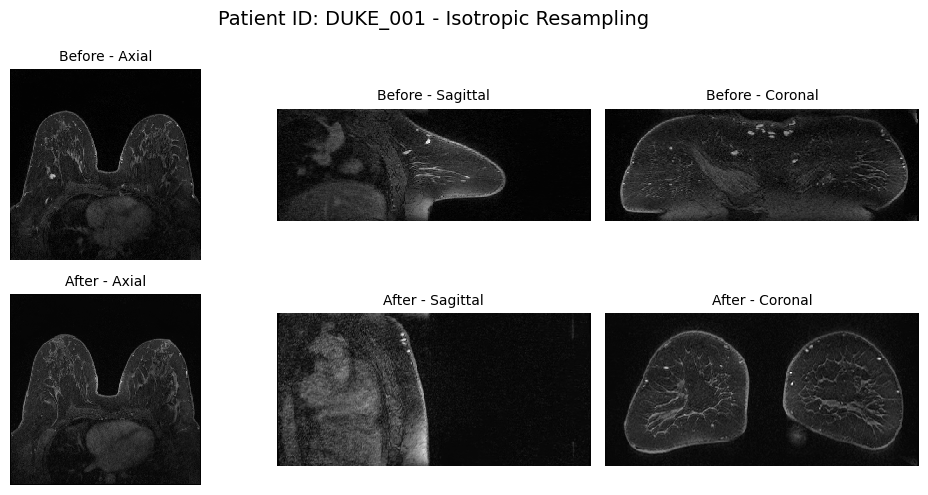

In [ ]:
# 6. Resampling (Recommended for DCE-MRI)
# Resampling is recommended to ensure that all the images have the same resolution and voxel size (e.g. 1x1x1 mm)

resampled_sitk = resample_sitk(normalized_stik, new_spacing=[1, 1, 1], interpolator=sitk.sitkBSpline)
# After resampling, the resampled images have a different size
print('Original image size:', normalized_stik.GetSize())
print('Resampled image size:', resampled_sitk.GetSize())

# We will display the original and resampled images side by side (after resampling the displayed slices are different):
plot_mri_preprocessing(normalized_stik, resampled_sitk, patient_id, preprocessing_method='Isotropic Resampling', figsize=(10, 5))
# Run to play with an interactive plot (the maximum slice showed if the maximum size before resmapling)
# interactive_plot_mri_preprocessing(normalized_stik, resampled_sitk, patient_id, preprocessing_method='Isotropic Resampling', figsize=(10, 5))

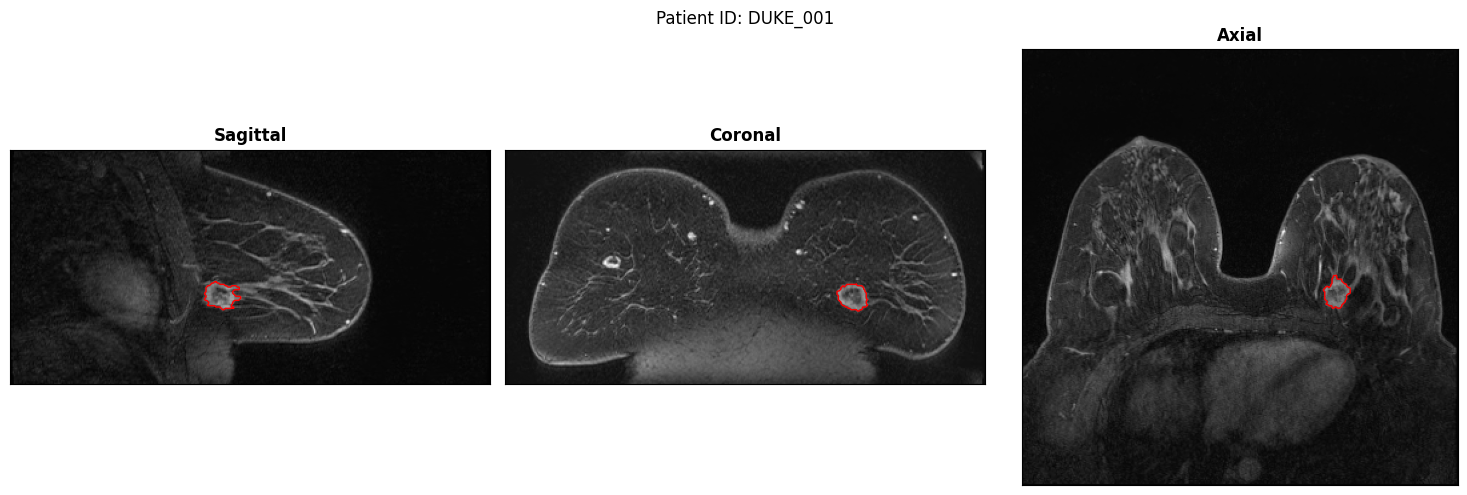

In [10]:
# If resampling is applied, the segmentations should be resampled as well
expert_segmentation_sitk = read_segmentation_from_patient_id(expert_segmentations, patient_id)

# Important: use the Nearest Neighbor interpolation to avoid introducing new labels
resampled_expert_segmentation_sitk = resample_sitk(expert_segmentation_sitk, new_spacing=[1, 1, 1], interpolator=sitk.sitkNearestNeighbor)

# Display the preprocessed MRI image and expert segmentation
plot_mri_and_segmentation(resampled_sitk, resampled_expert_segmentation_sitk, patient_id)

# Run to play with an interactive plot
# interactive_plot_mri_and_segmentation(resampled_sitk, resampled_expert_segmentation_sitk, patient_id, figsize=(15, 5))